# Result and Conclusion
VGG16 model is consided for image classification.

1. VGG16 Model build from scratch

- Model loss: 0.0217 - accuracy: 0.9974 at 200 epochs with Google Colab
- Hyper parameter changed
- added dropout layer
- added normalization later
- changed optimizers from adam to sgd (sgd perform better)
- gradual increase in learning rate 0.00001 --> 0.001
- increase number of ephocs to 200

2. Transfer learning with VGG16
- Model has loss: 0.0430 and accuracy: 0.9895 in only 20 epochs.

# Python libraries

In [1]:
#for data preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import cv2
import os
from PIL import Image #pillow for displaying image
from IPython import display  #Ipython for displaying image

#for model building
import tensorflow as tf
import keras,os
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D, Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout, Input

# Performance analysis
from sklearn.metrics import classification_report,confusion_matrix

# Data insight

In [2]:
#Loading data
df=pd.read_csv('data.csv',index_col = 0)

In [3]:
df.head()

,layer,quadrant,crop,plant_id,label,image_path
0,a,8,Rocket,19.0,prototype,imagesV2/1100/rgb_ce69a3d2-4623-47e5-b7d5-f0cd...
1,a,9,Rocket,19.0,prototype,imagesV2/1100/rgb_ce69a3d2-4623-47e5-b7d5-f0cd...
2,b,4,Rocket,19.0,layout_8,imagesV2/1114/rgb_5b23e086-1365-48a2-af39-defa...
3,b,7,Rocket,19.0,layout_8,imagesV2/1114/rgb_5b23e086-1365-48a2-af39-defa...
4,a,6,Basil,10.0,layout_8,imagesV2/1076/rgb_07febd91-f809-4f68-b3fc-c3c2...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 545 entries, 0 to 544
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   layer       545 non-null    object 
 1   quadrant    545 non-null    int64  
 2   crop        545 non-null    object 
 3   plant_id    545 non-null    float64
 4   label       545 non-null    object 
 5   image_path  545 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 29.8+ KB


In [5]:
df.shape  #changing the shape of df

(545, 6)

In [7]:
#checking total null values
df.isna().sum()

layer         0
quadrant      0
crop          0
plant_id      0
label         0
image_path    0
dtype: int64

<AxesSubplot:>

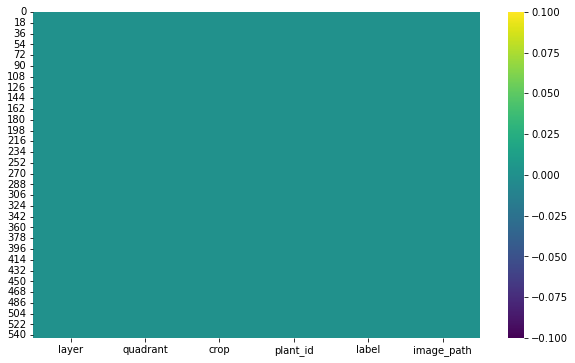

In [8]:
#Heatmap for checking null values
plt.figure(figsize = (10,6)) 
sns.heatmap(df.isnull(),cmap='viridis')

In [10]:
#checking correlation
df.corr()

,quadrant,plant_id
quadrant,1.000000,0.067196
plant_id,0.067196,1.000000


In [11]:
df['quadrant'].unique()

array([8, 9, 4, 7, 6, 1, 2, 3])

Text(0.5, 1.0, 'label')

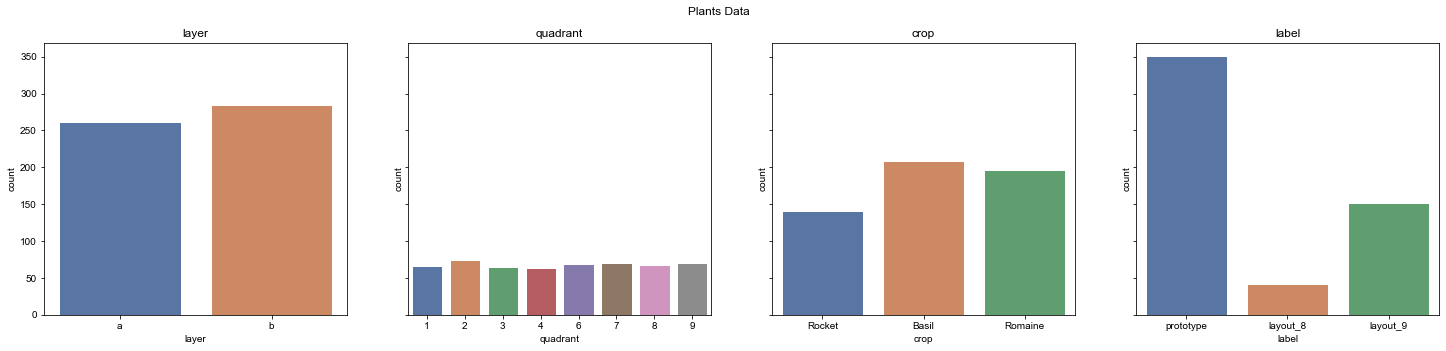

In [12]:
#Visualizing the data
fig, axes = plt.subplots(1, 4, figsize=(25, 5), sharey=True)
fig.suptitle('Plants Data')
sns.set_theme(style='whitegrid')

sns.countplot(ax=axes[0], x=df['layer'])
axes[0].set_title(df['layer'].name)

sns.countplot(ax=axes[1], x=df['quadrant'])
axes[1].set_title(df['quadrant'].name)

sns.countplot(ax=axes[2], x=df['crop'])
axes[2].set_title(df['crop'].name)

sns.countplot(ax=axes[3], x=df['label'])
axes[3].set_title(df['label'].name)

2    96
8    36
1    15
4     8
3     6
Name: image_path, dtype: int64


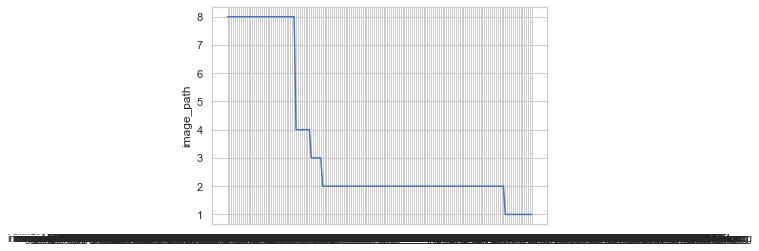

In [16]:
#Checking the unique images
sns.lineplot(data = df['image_path'].value_counts())

print(df['image_path'].value_counts().value_counts())

# Data cleaning

In [17]:
#Droping columns number 4 (plant ID is same as crop)
# df=df.drop(df.columns[[4]], axis=1) plant_id
df=df.drop(columns=['plant_id'], axis=1)

In [18]:
#Slicing image name from image path
image_name=[]
for i in range (0,len(df['image_path'])):
    # df['image_path'][i]=df['image_path'][i][6:]
    image=df['image_path'][i][14:]
    image_name.append(image)

In [19]:
# creating new column for image name
df['image_name']=image_name

In [20]:
#Dropping column image_path as it is no more required
df=df.drop(['image_path'], axis=1)

In [21]:
#Change name of column label to layout
df.rename(columns = {'label' : 'layout'}, inplace = True)

In [22]:
df.head()

,layer,quadrant,crop,layout,image_name
0,a,8,Rocket,prototype,rgb_ce69a3d2-4623-47e5-b7d5-f0cd0d968495_A_202...
1,a,9,Rocket,prototype,rgb_ce69a3d2-4623-47e5-b7d5-f0cd0d968495_A_202...
2,b,4,Rocket,layout_8,rgb_5b23e086-1365-48a2-af39-defa77768aa5_B_202...
3,b,7,Rocket,layout_8,rgb_5b23e086-1365-48a2-af39-defa77768aa5_B_202...
4,a,6,Basil,layout_8,rgb_07febd91-f809-4f68-b3fc-c3c24decafdf_A_202...


# Image Cropping and Mapping

In [23]:
#Getting path of Image 
home=os. getcwd()
path=os.path.join(home, 'images', df['image_name'][3])
path

'/Users/gauravsharma/Documents/Work/Coding/agrilution-coding_challenge_2/images/rgb_5b23e086-1365-48a2-af39-defa77768aa5_B_2020-11-10_09-58.png'

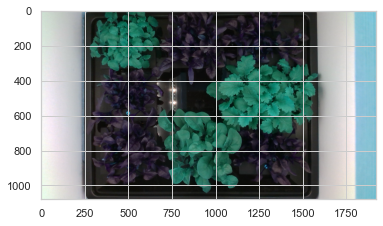

(1080, 1920, 3)


In [24]:
#Viewing the image
img= cv2.imread(path)
plt.figure()
plt.imshow(img) # only show image
plt.show()
print(img.shape) #checking image shape (HxW) 

# cv2.imshow('image',img)
# cv2.waitKey(0) # waits until a key is pressed
# cv2.destroyAllWindows() # destroys the window showing image

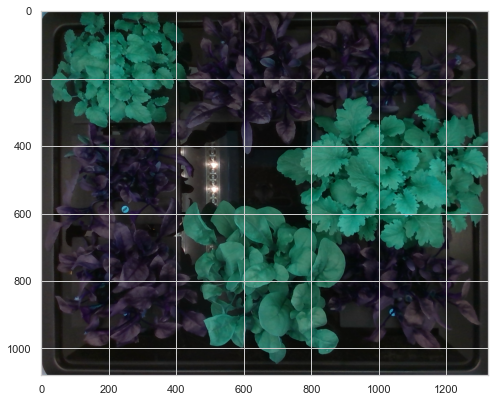

(1080, 1323, 3)


In [26]:
#Cropping image to get more relavent image area (EXPERIMENT)
cropped_img = img[:, 250:1573] # Height(from:to) x width(from:to)

plt.figure(figsize=(8,8))
# plt.figure(figsize=(cropped_img.shape[0]/2,cropped_img.shape[1]/2))
plt.imshow(cropped_img) 
plt.show() 
print(cropped_img.shape)

In [27]:
# #Save a copy of image with more relevent area (Optional)
# home=os. getcwd()
# for item in df['image_name']:  
#     path_img=os.path.join(home,'images', item) #path of existing image folder
#     img= cv2.imread(path_img)
#     cropped_img = img[:, 250:1573]
#     dir_new_img=os.path.join(home, 'new_images')  #new image dir
#     if not os.path.exists(dir_new_img): # make directory if not available
#         os.makedirs(dir_new_img)
#     path_new_img=os.path.join(dir_new_img,item) #path of crop image
#     cv2.imwrite(path_new_img,cropped_img) #Save file to resired folder

In [28]:
#Function for cropping each image and saving in respective image folder
#quadrant 1,2,3,7,8,9 are same for layout 8,9 & prototype
#quadrant 4,6 is same in layout_9 & prototype and different in layout_8

home=os. getcwd()
r=len(df['image_name'])
for i in range (0,r):
    path_original=os.path.join(home, 'images', df['image_name'][i])
    img= cv2.imread(path_original)
    if   df['quadrant'][i]==1: h, w=0, 0   
    elif df['quadrant'][i]==2: h, w=0, 640*1
    elif df['quadrant'][i]==3: h, w=0, 640*2
    elif df['quadrant'][i]==7: h, w=360*2, 0
    elif df['quadrant'][i]==8: h, w=360*2, 640*1
    elif df['quadrant'][i]==9: h, w=360*2, 640*2
    elif df['quadrant'][i]==4: 
        if df['layout'][i]=='layout_9' or df['layout'][i]=='prototype': h, w=360, 0   #layout_9 & prototype
        else: h, w=360, 320   #layout_8
    elif df['quadrant'][i]==6:
        if df['layout'][i]=='layout_9' or df['layout'][i]=='prototype': h, w=360, 640*2    #layout_9 & prototype
        else: h, w=360, 960  #layout_8
    try:
        crop_img = img[h:h+360, w:w+640]  #Cropping image
        plant_name=df['crop'][i] 
        path_crop_img_folder=os.path.join(home, 'crop_images',plant_name) # path of crop img folder
        if not os.path.exists(path_crop_img_folder): # make directory if not available
            os.makedirs(path_crop_img_folder)
        path_crop_img=os.path.join(path_crop_img_folder,plant_name + '_' + str(i) + '.jpg') #path of crop image
        cv2.imwrite(path_crop_img,crop_img) #Save file to resired folder
    except: #Show message if cropping failed
        print(f"Cropping failed for --crop {df['crop'][i]} --image {df['image_name'][i]} --quadrant {df['quadrant'][i]} --{df['layout'][i]}")


# Data Preprocessing

In [44]:
##creating dataframe from crop_data

#Get list of folders inside folder crop_images
image_all=os.listdir('crop_images') 
# path_dataset=os.listdir(os.path.join('crop_images',image_all[0]))

#creating crop data= [crop_name, image_name] for model
crop_data=[]
for item in image_all:
    try:
        crop=os.listdir('crop_images'+'/'+item)
        #looping through each image & append to create list
        for image in crop:
            crop_data.append((item, str('crop_images'+'/'+item)+'/'+ image))  #for image path+name
            # crop_data.append((item, image))  #for image name
    except: 
        pass

#creating dataframe from crop_data
crop_df=pd.DataFrame(data=crop_data,columns=['crop_name','image'])

In [45]:
#View crop dataframe
crop_df

,crop_name,image
0,Romaine,crop_images/Romaine/Romaine_339.jpg
1,Romaine,crop_images/Romaine/Romaine_59.jpg
2,Romaine,crop_images/Romaine/Romaine_71.jpg
3,Romaine,crop_images/Romaine/Romaine_463.jpg
4,Romaine,crop_images/Romaine/Romaine_311.jpg
...,...,...
540,Rocket,crop_images/Rocket/Rocket_149.jpg
541,Rocket,crop_images/Rocket/Rocket_410.jpg
542,Rocket,crop_images/Rocket/Rocket_404.jpg
543,Rocket,crop_images/Rocket/Rocket_438.jpg


In [46]:
#confirming the crop counts
print(crop_df['crop_name'].value_counts())
print(crop_df['crop_name'].value_counts().sum())

Basil      208
Romaine    196
Rocket     141
Name: crop_name, dtype: int64
545


In [47]:
crop_df['image'][2]

'crop_images/Romaine/Romaine_71.jpg'

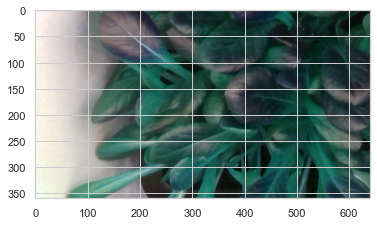

In [48]:
img=crop_df['image'][10]
img= cv2.imread(img)
plt.imshow(img) 
plt.show() 

In [50]:
len(crop_df['image'])

545

In [51]:
#Resize image to 224x224 for VGG16 model
resize_img=[]
crop_name=[]
for i in range (0,len(crop_df['image'])):
    path=crop_df['image'][i]
    crop=crop_df['crop_name'][i]
    img= cv2.imread(path)
    try:
        img=cv2.resize(img,(224,224))  #resize
        resize_img.append(img) #append all resize image
        crop_name.append(crop) #append only if resize is success
    except:
        print(f'Resize failed for {item}')

In [52]:
#confrim the data length
print(f'Length of resize image dataset is {len(resize_img)}')
print(f'Lenght of crop dataset is {len(crop_name)}')

Length of resize image dataset is 545
Lenght of crop dataset is 545


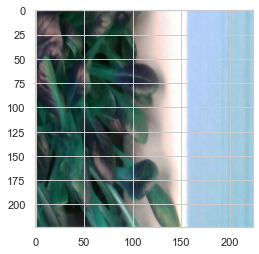

Romaine


In [53]:
plt.imshow(resize_img[9]) 
plt.show() 
print(crop_name[9])

In [54]:
resize_img=np.array(resize_img) #converting into np array
resize_img=resize_img.astype('float32')/255.0
resize_img.shape

(545, 224, 224, 3)

In [55]:
crop_name[:9]

['Romaine',
 'Romaine',
 'Romaine',
 'Romaine',
 'Romaine',
 'Romaine',
 'Romaine',
 'Romaine',
 'Romaine']

In [56]:
#label encoding and onehot encoding for crop classes
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

y=np.array(crop_name) #convert list into np array
y=y.reshape(-1,1) #reshape for columntransformer
ct = ColumnTransformer([('encoder',OneHotEncoder(),[0])], remainder = 'passthrough') #(name, transfor type, target_column), remainder= 'drop' or 'passthrough
y_encode=ct.fit_transform(y)

In [57]:
print(y_encode[:9])
print(y_encode.shape)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
(545, 3)


In [58]:
#inverse onehotencoder
ohe=OneHotEncoder()
ohe.fit(y)
print(ohe.categories_)
inverse_ohe=ohe.inverse_transform(y_encode)

[array(['Basil', 'Rocket', 'Romaine'], dtype='<U7')]


In [59]:
inverse_ohe[:9]

array([['Romaine'],
       ['Romaine'],
       ['Romaine'],
       ['Romaine'],
       ['Romaine'],
       ['Romaine'],
       ['Romaine'],
       ['Romaine'],
       ['Romaine']], dtype='<U7')

In [60]:
#Train test split
from keras.backend import random_normal
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#randomize dataset
resize_img, y_encode=shuffle(resize_img,y_encode, random_state=1) 

#train test split
X_train, X_test, y_train, y_test = train_test_split(resize_img, y_encode, test_size=0.3, random_state=42)

In [61]:
#Cheking the shape train and test dataset
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(381, 224, 224, 3)
(381, 3)
(164, 224, 224, 3)
(164, 3)


In [62]:
print(X_train[0])
print('===================================')
print(y_train[:9])

[[[0.2627451  0.28235295 0.2784314 ]
  [0.24705882 0.26666668 0.2627451 ]
  [0.24705882 0.26666668 0.2627451 ]
  ...
  [0.53333336 0.7372549  0.8039216 ]
  [0.5254902  0.73333335 0.8117647 ]
  [0.5254902  0.7137255  0.80784315]]

 [[0.25882354 0.2784314  0.27450982]
  [0.2509804  0.27058825 0.26666668]
  [0.24705882 0.26666668 0.25882354]
  ...
  [0.53333336 0.7411765  0.80784315]
  [0.5294118  0.7294118  0.80784315]
  [0.5294118  0.7176471  0.8117647 ]]

 [[0.25490198 0.2784314  0.27058825]
  [0.24705882 0.26666668 0.25882354]
  [0.23921569 0.25882354 0.2509804 ]
  ...
  [0.5411765  0.7411765  0.80784315]
  [0.5294118  0.7294118  0.8039216 ]
  [0.53333336 0.7176471  0.80784315]]

 ...

 [[0.3764706  0.38431373 0.3764706 ]
  [0.35686275 0.36078432 0.36862746]
  [0.32941177 0.32156864 0.32941177]
  ...
  [0.5529412  0.73333335 0.8       ]
  [0.5686275  0.7411765  0.80784315]
  [0.57254905 0.74509805 0.8117647 ]]

 [[0.34901962 0.36862746 0.3647059 ]
  [0.34901962 0.3529412  0.36862746]


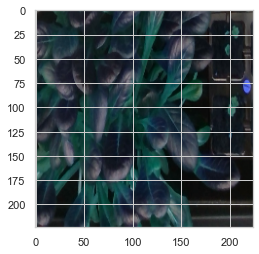

Romaine


In [63]:
plt.imshow(X_train[5]) 
plt.show() 
print(crop_name[9])

# Model building & training

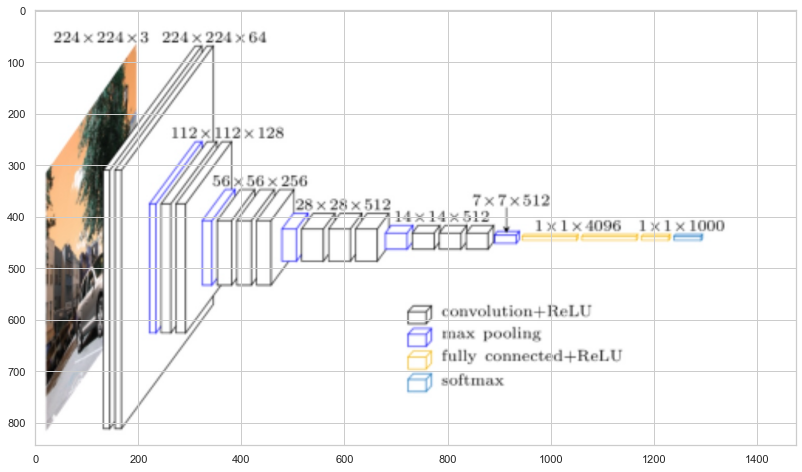

In [64]:
plt.figure(figsize=(20, 8))
img= cv2.imread('vgg16.jpg')
plt.imshow(img) 
plt.show() 

In [65]:
model = Sequential()
#layer 1
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")) #RELU stop forwarding negative values through the network
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#layer 2
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#layer 3
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#layer 4
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#layer 5
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#fully connected layer
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dropout(0.2))  #to prevent overfitting
model.add(Dense(units=4096,activation="relu"))
model.add(BatchNormalization()) 
model.add(Dropout(0.2)) 
model.add(Dense(units=3, activation="softmax"))  #classification block for classes 3

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-10-02 16:33:52.657985: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-02 16:33:52.659228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [66]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [67]:
#Model compilation
# opt = Adam(learning_rate=0.01)
opt = SGD(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [68]:
model_details= model.fit(X_train,y_train,epochs=10, batch_size=32)

Epoch 1/10


2022-10-02 16:34:21.683047: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-02 16:34:22.171303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 33s 3s/step - loss: 1.0942 - accuracy: 0.3832
Epoch 2/10
12/12 [==============================] - 29s 2s/step - loss: 1.0868 - accuracy: 0.4619
Epoch 3/10
12/12 [==============================] - 31s 3s/step - loss: 1.0784 - accuracy: 0.4514
Epoch 4/10
12/12 [==============================] - 29s 2s/step - loss: 1.0721 - accuracy: 0.4619
Epoch 5/10
12/12 [==============================] - 40s 3s/step - loss: 1.0651 - accuracy: 0.4567
Epoch 6/10
12/12 [==============================] - 32s 3s/step - loss: 1.0534 - accuracy: 0.4593
Epoch 7/10
12/12 [==============================] - 39s 3s/step - loss: 1.0480 - accuracy: 0.4803
Epoch 8/10
12/12 [==============================] - 32s 3s/step - loss: 1.0420 - accuracy: 0.4803
Epoch 9/10
12/12 [==============================] - 32s 3s/step - loss: 1.0274 - accuracy: 0.5092
Epoch 10/10
12/12 [==============================] - 31s 3s/step - loss: 1.0168 - accuracy: 0.5039


# Tranfer Learning with VGG16

In [72]:
# import VGG16 model with pre-trained weights from imagenet
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')

# summary of convolution base of VGG16 model
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [73]:
# Initialize a sequential model to group a linear stack of layers
model = Sequential()
base_model.trainable=False #to prevent training of pre-trained weights
model.add(base_model) # add VGG16 base model to initialize sequential model
model.add(GlobalAveragePooling2D()) # add global average pooling layer

# add densely-connected NN layer with 512 hidden units
model.add(Dense(units=512, activation='relu'))  # use ReLU activation function
model.add(BatchNormalization())                 # normalize and scale inputs or activations
model.add(Dropout(0.2))                         # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 128 hidden units
model.add(Dense(units=128, activation='relu')) # use ReLU activation function
model.add(BatchNormalization())                # normalize and scale inputs or activations
model.add(Dropout(0.2))                        # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 6 hidden units
model.add(Dense(units=3, activation='softmax')) # use Softmax activation function to do final predictions

In [74]:
# summary of custom VGG16
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [75]:
#Model compilation
# opt = Adam(learning_rate=0.001)
opt = SGD(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [77]:
model_details=model.fit(X_train,y_train, epochs=20, verbose=1)

Epoch 1/20
12/12 [==============================] - 8s 610ms/step - loss: 0.2142 - accuracy: 0.9318
Epoch 2/20
12/12 [==============================] - 7s 598ms/step - loss: 0.1859 - accuracy: 0.9344
Epoch 3/20
12/12 [==============================] - 7s 613ms/step - loss: 0.1946 - accuracy: 0.9213
Epoch 4/20
12/12 [==============================] - 8s 635ms/step - loss: 0.1639 - accuracy: 0.9501
Epoch 5/20
12/12 [==============================] - 8s 647ms/step - loss: 0.1972 - accuracy: 0.9370
Epoch 6/20
12/12 [==============================] - 8s 660ms/step - loss: 0.1841 - accuracy: 0.9396
Epoch 7/20
12/12 [==============================] - 8s 666ms/step - loss: 0.1812 - accuracy: 0.9318
Epoch 8/20
12/12 [==============================] - 8s 664ms/step - loss: 0.1952 - accuracy: 0.9291
Epoch 9/20
12/12 [==============================] - 8s 664ms/step - loss: 0.1774 - accuracy: 0.9449
Epoch 10/20
12/12 [==============================] - 8s 665ms/step - loss: 0.1468 - accuracy: 0.9633

# Model Evaluation

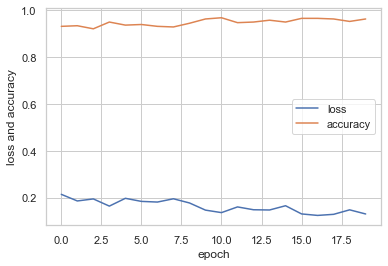

In [85]:
#Plot to show loss and accuracy
plt.plot(model_details.history['loss'], label='loss')
plt.plot(model_details.history['accuracy'], label='accuracy')
plt.legend()
plt.ylabel('loss and accuracy')
plt.xlabel('epoch')
plt.savefig('model_performance.jpg') #Save figure
plt.show()

In [400]:
#Save or load existing model
# model.save_weights('vgg16_crop_1.h5')  #save existing model
# model.load_weights('vgg16_crop_2.h5')  #laod existing model

2022-10-02 16:48:24.420692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 3s 582ms/step
[[67  3  0]
 [ 2 35  1]
 [ 2  2 52]]


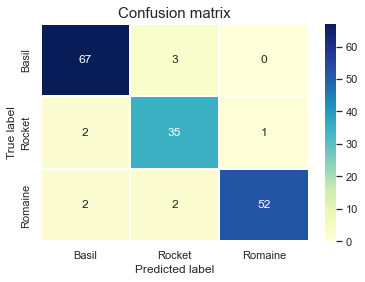

In [79]:
predictions = model.predict(X_test)  #prediction from test data in form of probability
class_test = np.argmax(y_test, axis=1) # np.argmax -->Returns the indices of the maximum values along an axis.
class_predict = np.argmax(predictions, axis=1)
#confustion matrix
confs_mat = confusion_matrix(class_test, class_predict)
print(confs_mat)

#confustion matrix heat plot
class_labels = ['Basil', 'Rocket', 'Romaine']
sns.heatmap(confs_mat, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.jpg') #Save figure
plt.show()

In [99]:
class_test

array([1, 2, 2, 1, 2, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 2, 0, 2, 2,
       0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0, 2, 0, 1, 0, 0, 2, 0, 1, 2, 1, 2,
       0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 2,
       1, 2, 0, 2, 0, 1, 2, 2, 2, 0, 1, 2, 1, 0, 0, 0, 0, 2, 0, 1, 0, 1,
       2, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 0, 0, 0, 0, 0,
       2, 1, 2, 2, 1, 2, 0, 1, 0, 0, 0, 1, 0, 0, 2, 2, 0, 1, 0, 0, 2, 0,
       0, 1, 0, 0, 2, 1, 2, 0, 1, 1, 2, 0, 0, 2, 1, 0, 1, 1, 0, 1, 1, 2,
       2, 2, 2, 1, 1, 2, 2, 1, 0, 2])

In [98]:
class_predict

array([1, 2, 2, 1, 2, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 2, 0, 2, 2,
       0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0, 2, 0, 1, 0, 0, 2, 0, 1, 2, 1, 2,
       0, 0, 2, 0, 2, 2, 2, 1, 2, 2, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 2,
       1, 2, 0, 2, 0, 1, 2, 2, 2, 0, 1, 2, 1, 0, 0, 0, 0, 2, 0, 1, 0, 1,
       2, 1, 1, 1, 0, 0, 1, 2, 1, 2, 2, 0, 1, 2, 2, 0, 2, 0, 0, 0, 0, 0,
       1, 0, 2, 2, 1, 2, 0, 1, 0, 0, 0, 1, 0, 0, 2, 2, 0, 1, 0, 0, 2, 0,
       0, 0, 0, 0, 2, 1, 2, 0, 2, 1, 2, 0, 0, 2, 1, 0, 1, 1, 0, 1, 1, 0,
       2, 2, 2, 1, 1, 2, 2, 1, 0, 2])